# Universal Pleasantness: Bayesian Modeling

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
from copy import copy
import os
os.environ['OUTDATED_IGNORE']='1'
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import pathlib
import seaborn as sns
from tqdm.auto import tqdm
sns.set(font_scale=1.2)
import univple as up

## Load the data and show the ranking for each odorant

In [3]:
data = {}
data['raw'], odorants = up.load_data()
groups, group_ids = up.get_groups(data['raw'])
data['raw'].head()  # First 5 rows

OdorName              1-Octen-3-ol  2-Isobutyl-3-methoxypyrazine  \
Group    Participant                                               
American 1                       1                             6   
         2                       6                             8   
         3                       5                             3   
         4                       4                             8   
         5                       4                             6   

OdorName              2-Phenylethanol  Diethyl disulfide  Ethyl butyrate  \
Group    Participant                                                       
American 1                          1                  8               9   
         2                          5                  9               1   
         3                          4                  6               7   
         4                          2                  7               1   
         5                          9                  7               3   

OdorName              Eugenol  Isovaleric acid  Linalool  Octanoic acid  \
Group    Participant                                                      
American 1                  3               10         5              7   
         2                  4                9         3              7   
         3                  1                8         2             10   
         4                  6               10         5              9   
         5                  1               10         5              8   

OdorName              Vanillin  
Group    Participant            
American 1                   4  
         2                   2  
         3                   9  
         4                   3  
         5                   2

## For modeling purposes, switch this to the odor index for rank 1, for rank 2, etc. for each subject

In [4]:
data['ranked'], odorants = up.load_data(by='ranks')
groups, group_ids = up.get_groups(data['ranked'])
data['ranked'].head()  # First 5 rows

1st  2nd  3rd  4th  5th  6th  7th  8th  9th  10th
Group    Participant                                                   
American 1              1    3    6   10    8    2    9    4    5     7
         2              5   10    8    6    3    1    9    2    4     7
         3              6    8    2    3    1    4    5    7   10     9
         4              5    3   10    1    8    6    4    2    9     7
         5              6   10    5    1    8    2    4    9    3     7

In [5]:
# Reset subject indices for Maniq to be ascending integers from 1 to make modeling easier
z = data['ranked'].reset_index()
n_maniq = (z['Group']=='Maniq').sum()
z.loc[z['Group']=='Maniq', 'Participant'] = range(1, n_maniq+1)
data['ranked'] = z.set_index(['Group', 'Participant']).sort_index()

### Generate pseudo-replicates based on lab test/retest

In [5]:
cols = ['Rater', 'Rep1', 'Rep2']
ttr = pd.read_csv('data/UniversalPleasantnessMainlandLabRanking.csv').set_index('CID')[cols]
rater_corrs = ttr.groupby('Rater').corr(method='kendall').unstack()[('Rep1', 'Rep2')]
target_tau = rater_corrs.median()
target_tau

0.8666666666666667

  0%|          | 0/250 [00:00<?, ?it/s]

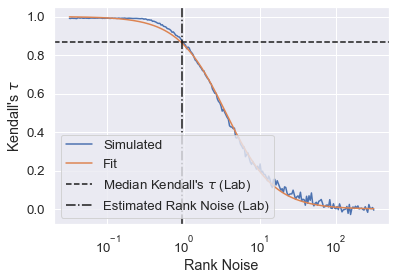

In [6]:
# Obtain the value of added rank noise that achieves
# the lab value of Kendall's tau
taus = pd.Series(index=np.logspace(-1.5, 2.5, 250), dtype=float)
pseudo_rep = data['raw'].stack().to_frame(name='Rep1')
for sigma in tqdm(taus.index):
    rank_noise = sigma*np.random.randn(*data['raw'].shape)
    reranked = (data['raw']+rank_noise).rank(axis=1).astype(int)
    pseudo_rep['Rep2'] = reranked.stack()
    kt = pseudo_rep.groupby(['Group', 'Participant']).corr(method='kendall')
    taus[sigma] = kt.unstack()[('Rep1', 'Rep2')].mean()

from scipy.optimize import curve_fit
from scipy.special import expit
def sigmoid(x, slope, midpoint):
    return expit(slope*(midpoint-np.log10(x)))

taus.plot(label='Simulated')
params, _ = curve_fit(sigmoid, taus.index, taus.values)
fitted_taus = pd.Series(sigmoid(taus.index, *params),
                        index=taus.index)
fitted_taus.plot(label='Fit')
sorted_taus = taus.copy().sort_values()
sorted_taus.index = taus.index[::-1]
idx = sorted_taus.searchsorted(target_tau)
target_sigma = sorted_taus.index[idx]

plt.xscale('log')
plt.xlabel('Rank Noise')
plt.ylabel(r"Kendall's $\tau$")
plt.axhline(target_tau, linestyle='--', color='k', label=r"Median Kendall's $\tau$ (Lab)")
plt.axvline(target_sigma, linestyle='-.', color='k', label='Estimated Rank Noise (Lab)')
plt.legend();

In [7]:
# Create these pseudo-replicates from this rank noise
while True:
    pseudo_rep = data['raw'].stack().to_frame(name='Rep1')
    rank_noise = target_sigma*np.random.randn(*data['raw'].shape)
    reranked = (data['raw']+rank_noise).rank(axis=1).astype(int)
    pseudo_rep['Rep2'] = reranked.stack()
    kt = pseudo_rep.groupby(['Group', 'Participant']).corr(method='kendall')
    achieved_tau = kt.unstack()[('Rep1', 'Rep2')].mean()
    if 0.99 < achieved_tau/target_tau < 1.01:
        break
pseudo_rep.columns.name = 'Rep'
data['raw-pseudo-replicated'] = pseudo_rep.stack('Rep').unstack('OdorName')

In [8]:
# Create a new ranks dataframe with the original ranks
# and the pseudo-replicated ranks
reps = []
for i in [1, 2]:
    raw = pseudo_rep['Rep%d' % i].unstack('OdorName')
    ranked = raw.apply(np.argsort, axis=1)+1
    ranked.columns = ranked.columns = \
                        ['1st', '2nd', '3rd'] + \
                        ['%dth' % x for x in range(4, 11)]
    reps.append(ranked)
# Make sure at least the first one unpacked correctly
assert up.load_data(by='ranks')[0].equals(reps[0])
data['ranked-pseudo-replicated'] = pd.concat(reps)

In [9]:
data['ranked-replicate-cloned'] = pd.concat([data['ranked'], data['ranked']])
data['shuffle-swap'] = up.shuffle_data(data['ranked'], groups, 'swap-individuals-within-culture')
data['ranked-replicate-swap'] = pd.concat([data['ranked'], data['shuffle-swap']])

### Estimating only the variance components without fitting the model to get all the coefficients

In [10]:
def make_synthetic(df, sigma_odor=3, sigma_group=1,
                   sigma_ind=3, sigma_noise=1):
    group_d = pd.get_dummies(df.index.get_level_values('Group'))
    ind_d = pd.get_dummies(df.index.droplevel('Rep').map(str))

    n_odors = df.shape[1]
    n_groups = group_d.shape[1]
    n_ind = ind_d.shape[1]
    n_trials = df.shape[0]
    
    odor_c = sigma_odor*np.random.randn(n_odors)
    group_c = sigma_group*np.random.randn(n_groups, n_odors)
    ind_c = sigma_ind*np.random.randn(n_ind, n_odors)
    noise = sigma_noise*np.random.randn(n_trials, n_odors)
    
    w = odor_c + group_d @ group_c + ind_d @ ind_c + noise
    w.columns = df.columns
    w.index = df.index
    return w.rank(axis=1)
    
data['synthetic'] = make_synthetic(data['raw-pseudo-replicated'])

In [11]:
def get_stats(df):
    # Standard deviation across trials, within odors
    a = df.std().mean()

    # Standard deviation across individuals, within odors
    b = df.groupby(['Group', 'Participant']).mean().std().mean()

    # Standard deviation across cultures, within odors
    c = df.groupby(['Group']).mean().std().mean()
    
    return np.array([a, b, c])

get_stats(data['raw-pseudo-replicated']), get_stats(data['synthetic'])

(array([2.24105205, 2.20344531, 0.75326005]),
 array([2.4550545 , 2.35840215, 0.91378753]))

In [13]:
from scipy.optimize import minimize

stats = get_stats(data['raw-pseudo-replicated'])

def f(x):
    syn_stats = []
    for i in range(100):
        syn = make_synthetic(data['raw-pseudo-replicated'], *x)
        syn_stats.append(get_stats(syn))
    syn_stats = np.mean(syn_stats, axis=0)
    err = np.sum((syn_stats - stats)**2)
    #print(err)
    return err

sigmas = pd.DataFrame(index=range(10),
                      columns=['σ_odor', 'σ_group', 'σ_individual', 'σ_noise'])
for i in tqdm(sigmas.index):
    result = minimize(f, [3, 1, 3, 1], bounds=[(0, None)]*4, method='Powell')
    sigmas.loc[i] = result.x

  0%|          | 0/10 [00:00<?, ?it/s]

KeyboardInterrupt: 

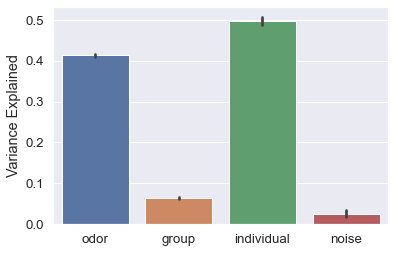

In [19]:
vars_explained = (sigmas**2).div((sigmas**2).sum(axis=1), axis=0).round(3)
vars_explained.columns = vars_explained.columns.map(lambda x: x.split('_')[1])
sns.barplot(data=vars_explained);
plt.ylabel('Variance Explained');

In [20]:
vars_explained.mean(), vars_explained.std()

(odor          0.412843
 group         0.063751
 individual    0.497603
 noise         0.025803
 dtype: float64,
 odor          0.007584
 group         0.004898
 individual    0.017154
 noise         0.013342
 dtype: float64)

## A Bayesian Model for Conducting the Same Analysis

In [6]:
# Compile the model, written in Stan (a probabilistic programming language for fitting Bayesian models)
model = up.load_or_compile_stan_model('univple-replicates')

In [7]:
samples = {}

In [8]:
name = 'ranked'
%time samples[name] = up.load_or_sample(model, data[name], name)


Gradient evaluation took 0.000626 seconds
1000 transitions using 10 leapfrog steps per transition would take 6.26 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000654 seconds
1000 transitions using 10 leapfrog steps per transition would take 6.54 seconds.
Adjust your expectations accordingly!


Iteration:     1 / 20000 [  0%]  (Warmup)
Iteration:     1 / 20000 [  0%]  (Warmup)

Gradient evaluation took 0.000628 seconds
1000 transitions using 10 leapfrog steps per transition would take 6.28 seconds.
Adjust your expectations accordingly!


Iteration:     1 / 20000 [  0%]  (Warmup)

Gradient evaluation took 0.000659 seconds
1000 transitions using 10 leapfrog steps per transition would take 6.59 seconds.
Adjust your expectations accordingly!


Iteration:     1 / 20000 [  0%]  (Warmup)
Iteration:  2000 / 20000 [ 10%]  (Warmup)
Iteration:  2000 / 20000 [ 10%]  (Warmup)
Iteration:  2000 / 20000 [ 10%]  (Warmup)
Iteration:  2000 / 20000 [ 10%]  (Warmup)
Iteratio

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


CPU times: user 4min 38s, sys: 29.7 s, total: 5min 8s
Wall time: 2h 50min 36s


In [17]:
name = 'ranked-replicate-cloned'
%time samples[name] = up.load_or_sample(model, data[name], name)

CPU times: user 32.4 s, sys: 3.69 s, total: 36.1 s
Wall time: 36.1 s


In [18]:
name = 'ranked-replicate-swap'
%time samples[name] = up.load_or_sample(model, data[name], name)

CPU times: user 32 s, sys: 3.67 s, total: 35.7 s
Wall time: 35.7 s


In [19]:
name = 'ranked-pseudo-replicated'
%time samples[name] = up.load_or_sample(model, data[name], name)


Gradient evaluation took 0.000944 seconds
1000 transitions using 10 leapfrog steps per transition would take 9.44 seconds.
Adjust your expectations accordingly!


Iteration:     1 / 20000 [  0%]  (Warmup)


Gradient evaluation took 0.00081 seconds
Gradient evaluation took 0.000814 seconds
1000 transitions using 10 leapfrog steps per transition would take 8.1 seconds.
1000 transitions using 10 leapfrog steps per transition would take 8.14 seconds.
Adjust your expectations accordingly!
Adjust your expectations accordingly!





Gradient evaluation took 0.001653 seconds
1000 transitions using 10 leapfrog steps per transition would take 16.53 seconds.
Adjust your expectations accordingly!


Iteration:     1 / 20000 [  0%]  (Warmup)
Iteration:     1 / 20000 [  0%]  (Warmup)
Iteration:     1 / 20000 [  0%]  (Warmup)
Iteration:  2000 / 20000 [ 10%]  (Warmup)
Iteration:  2000 / 20000 [ 10%]  (Warmup)
Iteration:  2000 / 20000 [ 10%]  (Warmup)
Iteration:  2000 / 20000 [ 10%]  (Warmup)
Iteration

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


CPU times: user 4min 3s, sys: 21.6 s, total: 4min 25s
Wall time: 2h 43min 55s


ranked
ranked-replicate-cloned
ranked-replicate-swap
ranked-pseudo-replicated


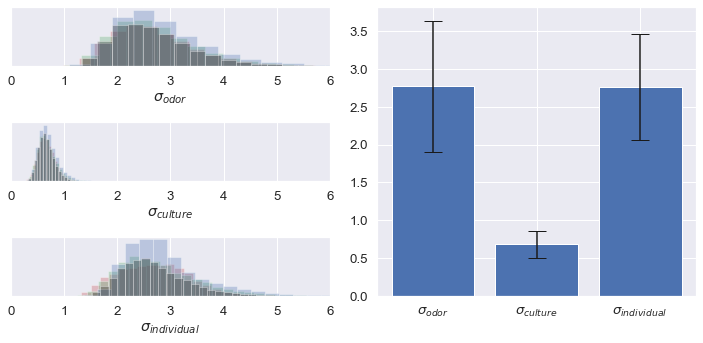

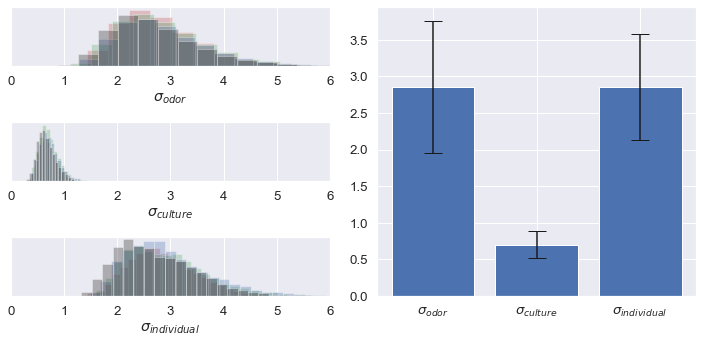

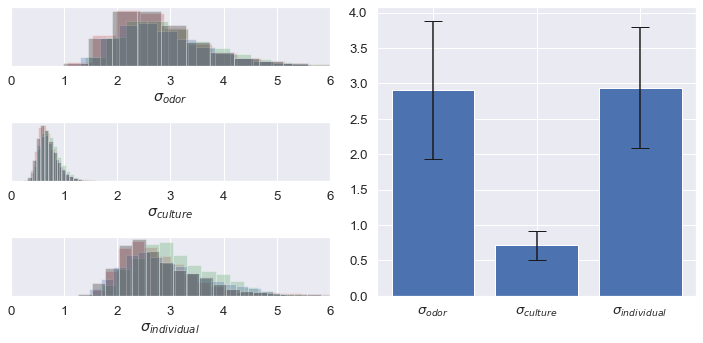

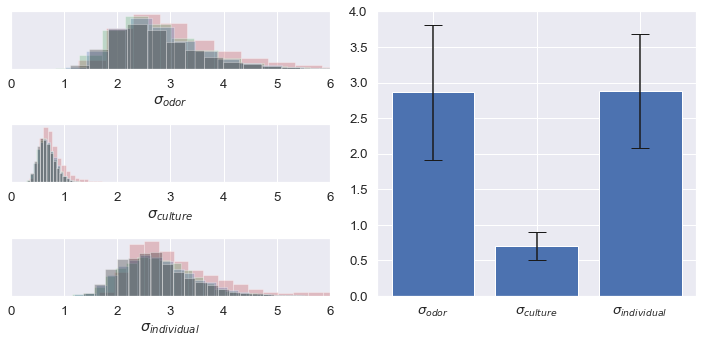

In [20]:
for name in ['ranked', 'ranked-replicate-cloned',
             'ranked-replicate-swap', 'ranked-pseudo-replicated']:
    print(name)
    up.plot_sigmas(samples[name], groups)
    if name == 'ranked':
        plt.savefig('Figure S5.png', dpi=600, format='png')
        plt.savefig('Figure S5.pdf', format='pdf')

In [9]:
# Create shuffles to be modeled as well.
shuffles = ['odors-within-culture', 'individuals']#, 'odors']
for shuffle in shuffles:
    data['shuffle-%s' % shuffle] = up.shuffle_data(data['ranked'], groups, shuffle)

In [10]:
# Fit the model to the real data and to the shuffled data
# This will take many hours (or days) if you have not already sampled from these models
# It will take a few minutes if you are just loading the samples
samples = {}
for shuffle in tqdm(['ranked'] + ['shuffle-%s' % shuffle for shuffle in shuffles]):
    %time samples[shuffle] = up.load_or_sample(model, data[shuffle], shuffle)

  0%|          | 0/3 [00:00<?, ?it/s]

CPU times: user 37 s, sys: 7.53 s, total: 44.5 s
Wall time: 44.7 s
CPU times: user 36.8 s, sys: 5.74 s, total: 42.5 s
Wall time: 42.6 s
CPU times: user 35.6 s, sys: 4.45 s, total: 40.1 s
Wall time: 40.1 s


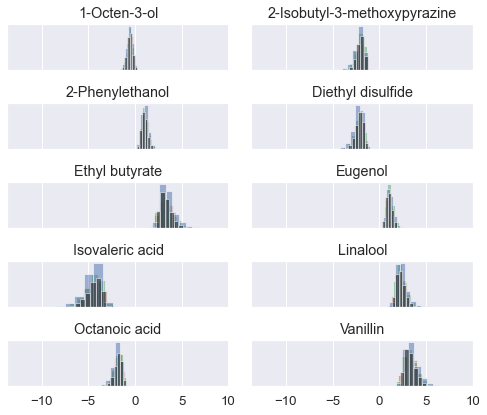

In [11]:
# Check if independent sampling chains (runs with different random starting points) agree on global odorant valences
# If each odorant produces 4 almost perfectly overlapping histograms,
# then the fit went well
up.plot_global_agreement(samples['ranked'], odorants)

## Model Consistency Check: Estimated valences and observed ranks are almost perfectly anti-correlated at the individual level (i.e. a high valence is a low (e.g. 1) rank.

In [ ]:
# Distribution of individual-level Pearson Correlation between observed rankings
# and estimated latent valences.  Should be close to -1
# (since lower ranking is more pleasant, but higher rating is more pleasant).
# Differs from exactly -1 due to a) the switch between a cardinal and ordinal measure
# and b) the denoising applied by the model
up.ranks_vs_values(samples['ranked'], groups)

## Show how the group mean valences for each odorant compare.  Order by global mean valence.

In [ ]:
up.plot_global_means(groups, odorants, samples['ranked'])

## Estimate contributions of each factor using the Bayesian model.

In [ ]:
up.plot_sigmas(samples['ranked'], groups)

## Verify that when the model is applied to the shuffled ranks, the contribution of universal valence disappears.  This is a negative control.

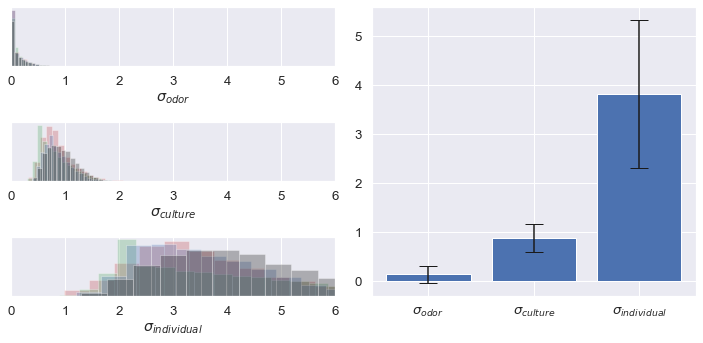

In [13]:
up.plot_sigmas(samples['shuffle-odors-within-culture'], groups)
plt.savefig('Figure S6.png', dpi=600, format='png')
plt.savefig('Figure S6.pdf', format='pdf')

## Valences are very highly correlated across groups (different groups ranks things similarly), but odorants are not really correlated with one another (how a group ranks one odorant does not closely predict how it will rank another odorant)

In [ ]:
up.get_means(samples['ranked'], groups, odorants, 'mu_group')

In [ ]:
up.corr_heatmaps(samples['ranked'], groups, odorants)

## For the shuffle control, this correlation structure (among groups) disappears

In [ ]:
up.corr_heatmaps(samples['shuffle-odors-within-culture'], groups, odorants)

## PCA shows that there is really only one principal component explaining most of the variance in cross-cultural odor ranking.  Operating in the other direction, on odorants, shows a higher-dimensional structure (recapitulates the point in the figures above).

In [ ]:
up.plot_var_explained(samples['ranked'], groups, odorants)

## The model estimates the intra-group standard deviations

In [ ]:
# Individual variability within a group
intragroup_std = pd.Series([samples['ranked']['sigma_ind[%d]' % x].mean() for x in range(1, len(groups)+1)], index=groups)
intragroup_std.sort_values().to_frame(name='Standard Deviation across Individuals').round(1)

## We can examine this more closely for each group, looking at the correlation in estimated odorant valences between individuals.  This shows that the Maniq are ranking in a way which is indistinguishable from random (red dashed line, KS-test p-value shown)

In [ ]:
up.plot_ind_corrs(data['ranked'], samples['ranked'], groups, odorants)

## We can look at the groups in a reduced dimension using PCA (big dots are group means, little dots are individuals; many individuals are far away from the mean, illustrating that individual variability (and noise) is large compared to the differences between groups.

In [ ]:
up.plot_all_individuals(samples['ranked'], groups, group_ids, odorants)

## We can then partition the groups into supergroups and ask if these supergroups explain the observed group structure

In [ ]:
supergroups = {'subsistence': {'Industrial': ['New York City', 'Thai', 'Mexican'],
                               'Agricultural': ['Semelai', 'Mah Meri', "Chachi", 'Imbabura Quechua'],
                               'Hunter-gatherer': ['Maniq', 'Semaq Beri', 'Seri']},
               'geography': {'North America': ['New York City', 'Seri', 'Mexican'],
                             'South America': ["Chachi", 'Imbabura Quechua'],
                              'Asia': ['Semelai', 'Mah Meri', 'Maniq', 'Semaq Beri', 'Thai']}}

In [ ]:
# Plot using PCA as above
up.plot_supergroups(samples['ranked'], groups, odorants, supergroups, method='PCA')

In [ ]:
# Plot using Multidimensional Scaling, another dimensionality reduction strategy
up.plot_supergroups(samples['ranked'], groups, odorants, supergroups, method='MDS')

## We next ask whether certain supergroups summarize the group structure.  We compare these groups to random group assignments of the same size to get p-values

In [ ]:
supergroup_stats = up.get_supergroup_stats(samples['ranked'], groups, odorants, supergroups)
supergroup_stats.to_frame(name='p')